In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    return "Done"

set_seed(42)

'Done'

In [3]:
array = np.linspace(0,119,120)
print(array)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119.]


In [4]:
test_size = 20
train_set = array[:-test_size]
test_set = array[-test_size:]

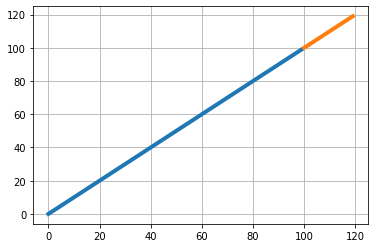

In [33]:
plt.plot(train_set,linewidth=4)
plt.grid(True)
plt.plot(test_set,range(100,120),linewidth=4)

In [34]:
def input_data(data,ws):
    out = []
    
    for i in range(len(data)-ws):
        feature = data[i:i+ws+1]
        out.append(feature)
        
    df = pd.DataFrame(out)
    return df

In [35]:
class CustomDatasetTrain(Dataset):
    def __init__(self):
        self.df = input_data(train_set,3)
        self.x = torch.from_numpy(self.df.drop(3,axis=1).to_numpy()).float()
        self.y = torch.from_numpy(self.df[3].to_numpy()).float()
        self.n_sample = self.df.shape[0]

    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return self.n_sample
    
train_data= CustomDatasetTrain()

In [36]:
class CustomDatasetTest(Dataset):
    def __init__(self):
        self.df = input_data(test_set,3)
        self.x = torch.from_numpy(self.df.drop(3,axis=1).to_numpy()).float()
        self.y = torch.from_numpy(self.df[3].to_numpy()).float()
        self.n_sample = self.df.shape[0]

    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return self.n_sample
    
test_data = CustomDatasetTest()

In [37]:
batch_size = 5

train_loader = DataLoader(train_data,batch_size)
test_loader = DataLoader(test_data,batch_size)

In [38]:
class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, linear_output, batch_size, bidirectional, batch_first):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size = input_size, 
                           hidden_size = hidden_size, 
                           num_layers = num_layers,
                           batch_first= batch_first,
                           bidirectional = bidirectional)
        
        self.linear = nn.Linear(hidden_size,12)
        self.linear_1 = nn.Linear(12,1)
    
    def forward(self,input_data):
        input_ = input_data.reshape(-1,3,1)
        output, (hidden,cell) = self.lstm(input_)
        pred = self.linear(hidden)
        pred = self.linear_1(pred)
        return pred 

In [50]:
model = LSTM(input_size = 1,
            hidden_size =100,
            num_layers = 1,
            linear_output = 1,
            batch_size= batch_size,
            bidirectional= False,
            batch_first= True)


loss_func = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(),lr=0.1)

In [51]:
print(model)

LSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=12, bias=True)
  (linear_1): Linear(in_features=12, out_features=1, bias=True)
)


In [52]:
epochs = 100
loss = 0

for epoch in range(epochs):
    for data,label in train_loader:
        optimizer.zero_grad()
        
        pred = model.forward(data)
        loss = loss_func(pred,label.reshape(1,-1,1))
        loss.backward()
        
        optimizer.step()
    print(loss.item())

7.261667728424072
6.281016826629639
62.613304138183594
513.844970703125
27.004194259643555
24.64120864868164
117.8323974609375
8.100905418395996
0.2804059684276581
0.384126752614975
2.750518321990967
39.18523406982422
9.35658073425293
8.14185905456543
22.531269073486328
5.924049377441406
4.369957447052002
5.368456840515137
20.289749145507812
6.258790969848633
2.98317289352417
4.19378137588501
13.150188446044922
3.4068708419799805
1.0066907405853271
0.12417532503604889
10.850921630859375
2.77927303314209
1.670929193496704
2.7157976627349854
2.442225456237793
2.3574037551879883
0.6970037221908569
0.17844310402870178
0.9293788075447083
3.5343337059020996
2.8454394340515137
3.1379432678222656
3.0461714267730713
2.99029541015625
13.935564041137695
4.337085247039795
1.7315173149108887
0.0535053014755249
5.637005805969238
1.4958786964416504
0.007551191840320826
0.3627510070800781
0.046694446355104446
0.083949975669384
2.187309741973877
0.9795809984207153
0.04004603251814842
0.1846550107002258

In [53]:
model.eval()
loss = 0
batch = 0
original = []
predi = []
with torch.no_grad():
    for data, label in test_loader:
        pred = model.forward(data)
        original.extend(label.tolist())
        predi.extend(pred[0].reshape(1,-1).tolist())
        loss += loss_func(pred,label.reshape(1,-1,1))
        print(label,pred)
        batch+=1
        
    print(f"Loss : {loss/batch}")

tensor([103., 104., 105., 106., 107.]) tensor([[[102.8363],
         [103.5428],
         [104.2391],
         [104.9305],
         [105.6216]]])
tensor([108., 109., 110., 111., 112.]) tensor([[[106.3168],
         [107.0202],
         [107.7357],
         [108.4667],
         [109.2159]]])
tensor([113., 114., 115., 116., 117.]) tensor([[[109.9847],
         [110.7719],
         [111.5731],
         [112.3798],
         [113.1786]]])
tensor([118., 119.]) tensor([[[113.9524],
         [114.6826]]])
Loss : 8.821504592895508


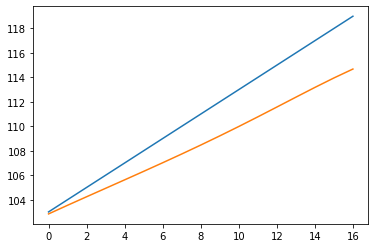

In [60]:
test = []
for i in predi:
    test.extend(i)

#test = [int(i) for i in test]
plt.plot(original)
plt.plot(test)

## Conclusion 


In [55]:
# Lstm Is working better with slight hyper-parameter tuining able to get results faster
# Change learning rate from 0.09 to 0.01 
# Its a many to one case